# Entrono #

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import GradientBoostingRegressor
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
import requests
import numpy as np
from fpdf import FPDF

In [2]:
# ----------------------------
# Pub/Sub Broker
# ----------------------------
class PubSubBroker:
    def __init__(self):
        self.subscribers = []

    def subscribe(self, callback):
        self.subscribers.append(callback)

    def publish(self, data):
        for callback in self.subscribers:
            callback(data)

# ----------------------------
# Whiteboard (memoria compartida)
# ----------------------------
class Whiteboard:
    def __init__(self):
        self.data = {}

    def write(self, key, value):
        self.data[key] = value

    def read(self):
        while len(self.data) < 2:
            print("Esperando datos en la pizarra... ", self.data)
            time.sleep(5)
        return dict(self.data)

    def clear(self):
        self.data = {}

# ----------------------------
# DataFetcher (Insertar agente de recolección de datos)
# ----------------------------
class DataFetcher:
    def __init__(self, dataframe):
        self.df = dataframe
        self.index = 0

    def has_next(self):
        return self.index < len(self.df)
    
    def get_next_ticker(self):
        if self.index < len(self.df):
            return self.df.iloc[self.index]['Ticker']
        return None

    def fetch_data(self):
        current = self.df.loc[self.index]
        self.index += 1
        return current
# ----------------------------

In [3]:
class traditionalAgent:
    def __init__(self, broker, whiteboard, data_fetcher):
        self.broker = broker
        self.whiteboard = whiteboard
        self.data_fetcher = data_fetcher
        self.df = None
        self.broker.subscribe(self.group_traditional)

    def set_dataframe(self, df):
        self.df = df

    def group_traditional(self, data):
        idx = self.data_fetcher.index
        if idx < 2 or self.df is None:
            self.whiteboard.write('trad_pred', data['Close'])
            return

        # Filtrar histórico por ticker actual
        df_hist = self.df.iloc[:idx].copy()
        df_hist = df_hist[df_hist['Ticker'] == data['Ticker']].reset_index(drop=True)

        if len(df_hist) < 10:
            self.whiteboard.write('trad_pred', data['Close'])
            return

        # Columnas predictoras
        features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'SMA_20', 'MACD']

        # Objetivo: Close futuro (t+1)
        df_hist['Close_Future'] = df_hist['Close'].shift(-1)
        df_hist = df_hist.fillna(method='ffill')

        try:
            X = df_hist[features]
            y = df_hist['Close_Future']
            current_features = np.array([data[f] for f in features]).reshape(1, -1)

            # pred1: Regresión lineal multivariable
            model1 = LinearRegression()
            model1.fit(X, y)
            pred1 = model1.predict(current_features)[0]

            # pred2: Gradient Boosting multivariable
            model2 = GradientBoostingRegressor()
            model2.fit(X, y)
            pred2 = model2.predict(current_features)[0]

        except Exception:
            pred1 = pred2 = data['Close']

        avg = (pred1 + pred2) / 2
        self.whiteboard.write('trad_pred', avg)

In [4]:
class AgenteIA:
    def __init__(self, broker, whiteboard, data_fetcher):
        self.broker = broker
        self.whiteboard = whiteboard
        #self.broker.subscribe(self.group_ai)
        self.data_fetcher = data_fetcher

        # Inicializa embeddings y base de datos vectorial
        self.embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
        self.db = None  # Se cargará después con documentos reales

    def cargar_documentos(self, ruta):
        documentos = []
        for archivo in os.listdir(ruta):
            if archivo.endswith(".txt"):
                documentos.extend(TextLoader(os.path.join(ruta, archivo)).load())
            elif archivo.endswith(".pdf"):
                documentos.extend(PyPDFLoader(os.path.join(ruta, archivo)).load())
        return documentos

    def dividir_chunks(self, documentos):
        splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
        return splitter.split_documents(documentos)

    def crear_o_cargar_chromadb(self, chunks, persist_directory="db_finanzas"):
        if not os.path.exists(persist_directory):
            self.db = Chroma.from_documents(chunks, self.embedding_function, persist_directory=persist_directory)
            self.db.persist()
        else:
            self.db = Chroma(persist_directory=persist_directory, embedding_function=self.embedding_function)

    def consulta_lmstudio(self, prompt):
        url = "http://localhost:1234/v1/chat/completions"
        headers = {"Content-Type": "application/json"}

        data = {
            "messages": [{
                "role": "system",
                "content": "Eres un asistente que responde SOLO con JSON, nunca expliques, nunca incluyas texto adicional.\n" + prompt
            }],
            "temperature": 0.4,
            "max_tokens": 1048
        }

        response = requests.post(url, headers=headers, json=data)
        return response.json()["choices"][0]["message"]["content"]

    def consulta_rag(self, pregunta):
        if self.db is None:
            raise Exception("La base de datos vectorial no ha sido cargada.")
        similares = self.db.similarity_search(pregunta, k=3)
        contexto = "\n\n".join([doc.page_content for doc in similares])

        prompt = f"""Con base en el siguiente contexto, responde la pregunta solo en formato JSON válido con claves 'fecha' y 'valor':

        Contexto:
        {contexto}

        Pregunta: {pregunta}
        """
        res = self.consulta_lmstudio(prompt)
        return res

    def group_ai(self, data):
        stock_symbol = data.get('Ticker')
        current_date = pd.to_datetime(data['Datetime'])
        df_stock = self.data_fetcher.df
        if current_date > pd.to_datetime("2025-07-15 00:00:00"):
            day_before = current_date - pd.Timedelta(days=1)
        else:
            day_before = pd.Timestamp("2025-07-11")
        
        df_filtrado = df_stock[(df_stock['Ticker'] == stock_symbol) & (pd.to_datetime(df_stock['Datetime']).dt.date == day_before.date())]
        
        
        if current_date < pd.to_datetime("2025-07-13"):
            self.whiteboard.write('ai_pred', data['Close'])  # fallback
            return
        min_close = df_filtrado['Close'].min()
        print("min", min_close)
        max_close = df_filtrado['Close'].max()
        print("max", max_close)
        df_historico = df_filtrado.sort_values(by='Datetime')
        texto_contexto_historico = df_historico.to_string(index=False)
        if self.data_fetcher.index > 1:
            last_close = self.data_fetcher.df.loc[self.data_fetcher.index - 2]['Close']
        else:
            last_close = data['Close']
            
        pregunta = f"""Dado el siguiente historial de precios del activo {stock_symbol}, ¿cuál sería una predicción razonable del valor de cierre para el día y la hora {current_date}?
        
        Historial:
        {texto_contexto_historico}
        El rango de precios del día anterior es:
        - Mínimo: {min_close}
        - Máximo: {max_close}
        
        Basado en este contexto y sin salirte mucho de este rango, predice el precio de cierre más probable para la fecha {current_date}
        Responde en formato JSON, un solo elemento con la siguiente estructura: {{ "fecha": "AAAA-MM-DD hh:mm ", "valor": <número> }} 
        """
        try:
            respuesta = self.consulta_rag(pregunta)
            resultado = eval(respuesta)
            print(resultado)
            print("----------------------------")
            avg = resultado['valor']
        except Exception as e:
            print("Error en predicción:", e)
            avg = last_close  # fallback
        self.whiteboard.read
        self.whiteboard.write('ai_pred', avg)

In [ ]:
class DecisionAgent:
    def __init__(self, histories):
        self.histories = histories
 
    def calcular_mape(self, real, pred):
        real, pred = np.array(real), np.array(pred)
        return np.mean(np.abs((real - pred) / real)) * 100
 
    def evaluar_decisiones(self):
        decisiones = {}
        for ticker, history in self.histories.items():
            real = history['Real_Close'].iloc[1:]
            ai_pred = history['AI_Prediction'].iloc[1:]
            mape = self.calcular_mape(real, ai_pred)

            last_pred1 = ai_pred.iloc[-1]
            last_pred2 = ai_pred.iloc[-1]

            if last_pred2 < last_pred1:
                movimiento = "Comprar 📈"
            elif last_pred2 > last_pred1:
                movimiento = "Vender 📉"
            else:
                movimiento = "Mantener 🤝"

            if mape > 10:
                decision = f"Predicción no confiable (MAPE alto) — Sugerido: {movimiento}"
            else:
                decision = movimiento

            decisiones[ticker] = {
                'MAPE': round(mape, 2),
                'DECISION': decision
            }
 
        return decisiones

In [6]:
# ----------------------------
# MarketEnvironment
# ----------------------------
class MarketEnvironment:
    def __init__(self, df):
        self.df = df
        self.data_fetcher = DataFetcher(df)
        self.broker = PubSubBroker()
        self.whiteboard = Whiteboard()
        self.histories = {}  # Diccionario para almacenar cada empresa

        # Agentes de predicción
        self.agentsTraditional = traditionalAgent(self.broker, self.whiteboard, self.data_fetcher)
        self.agentsIA = AgenteIA(self.broker, self.whiteboard, self.data_fetcher)
        self.agentsTraditional.set_dataframe(df)

        documentos = self.agentsIA.cargar_documentos("documentos")
        chunks = self.agentsIA.dividir_chunks(documentos)
        self.agentsIA.crear_o_cargar_chromadb(chunks)
        
        # Suscribir los grupos de agentes al broker
        self.broker.subscribe(self.agentsTraditional.group_traditional)
        self.broker.subscribe(self.agentsIA.group_ai)

    def run(self):
        tickers = self.df['Ticker'].unique().tolist()

        for ticker in tickers:
            print(f"Iniciando simulación para {ticker}...")

            df_ticker = self.df[self.df['Ticker'] == ticker].reset_index(drop=True)
            self.data_fetcher = DataFetcher(df_ticker)
            self.agentsTraditional.set_dataframe(df_ticker)

            self.histories[ticker] = pd.DataFrame(columns=['Datetime', 'Real_Close', 'Trad_Prediction', 'AI_Prediction'])

            # Primer paso: hacer la primera predicción (usando t)
            if not self.data_fetcher.has_next():
                continue
            current_data = self.data_fetcher.fetch_data()
            self.whiteboard.clear()
            self.broker.publish(current_data)
            last_prediction = self.whiteboard.read()  # ← esto reemplaza a last_data

            while self.data_fetcher.has_next():
                current_data = self.data_fetcher.fetch_data()

                # Guardar la predicción previa (hecha en t) contra el valor real de t+1
                self.histories[ticker].loc[len(self.histories[ticker])] = [
                    current_data['Datetime'],
                    current_data['Close'],
                    last_prediction.get('trad_pred', current_data['Close']),
                    last_prediction.get('ai_pred', current_data['Close'])
                ]

                #print(
                #    f"[{current_data['Datetime']}] {ticker} | "
                #    f"Real: {current_data['Close']:.2f} | "
                #    f"Tradicional: {last_prediction.get('trad_pred', current_data['Close']):.2f} | "
                #    f"IA: {last_prediction.get('ai_pred', current_data['Close']):.2f}"
                #)

                # Hacer predicción para t+2 usando datos de t+1
                self.whiteboard.clear()
                self.broker.publish(current_data)
                last_prediction = self.whiteboard.read()

            self.plot_graph(ticker)
            #self.histories[ticker].to_excel(f"simulacion_{ticker}.xlsx", index=False)
            print(f"✔ Terminó {ticker}")
        decision_agent = DecisionAgent(self.histories)
        decisiones = decision_agent.evaluar_decisiones()

        print("\n===== DECISIONES DE INVERSIÓN =====")
        # Crear PDF
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=12)
        pdf.cell(200, 10, txt="Resultados de MAPE y Recomendaciones", ln=True, align='C')
        pdf.ln(10)
        
        # En vez de print, escribir en PDF línea por línea
        for ticker, resultado in decisiones.items():
            linea = f"{ticker}: MAPE={resultado['MAPE']}% => {resultado['DECISION']}"
            pdf.cell(200, 10, txt=linea, ln=True)
        
        # Guardar el archivo
        pdf.output("resultados_mape.pdf")


    def plot_graph(self, ticker):
        history = self.histories[ticker]

        # Ignorar el primer punto
        history = history.iloc[1:]

        plt.figure(figsize=(12,5))
        plt.plot(history['Datetime'], history['Real_Close'], label='Precio Real', marker='o')
        plt.plot(history['Datetime'], history['Trad_Prediction'], label='Predicción Tradicional', linestyle='--', marker='x')
        plt.plot(history['Datetime'], history['AI_Prediction'], label='Predicción IA', linestyle='-.', marker='s')
        plt.legend()
        plt.title(f'Simulación Multiagente - {ticker}')
        plt.xlabel('Tiempo')
        plt.ylabel('Precio de Cierre')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


C:\Users\littl\AppData\Local\Temp\ipykernel_23208\495753925.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
d:\kike\Maestria\FUMU_F\FUMU\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\littl\AppData\Local\Temp\ipykernel_23208\495753925.py:30: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the c

Iniciando simulación para AAPL...
min 210.6349945068359
max 211.7899932861328
{'fecha': '2025-07-14 13:30', 'valor': 211.339998}
----------------------------
min 210.6349945068359
max 211.7899932861328
{'fecha': '2025-07-14 14:30', 'valor': 211.0}
----------------------------
min 210.6349945068359
max 211.7899932861328
{'fecha': '2025-07-14 15:30', 'valor': 211.449998}
----------------------------
min 210.6349945068359
max 211.7899932861328
{'fecha': '2025-07-14 16:30', 'valor': 211.449997}
----------------------------
min 210.6349945068359
max 211.7899932861328
{'fecha': '2025-07-14 17:30', 'valor': 211.0}
----------------------------
min 210.6349945068359
max 211.7899932861328
{'fecha': '2025-07-14 18:30', 'valor': 211.399994}
----------------------------
min 210.6349945068359
max 211.7899932861328
{'fecha': '2025-07-14 19:30', 'valor': 211.349998}
----------------------------
min 208.0299987792969
max 209.1999053955078
{'fecha': '2025-07-15 13:30', 'valor': 209.0}
------------------

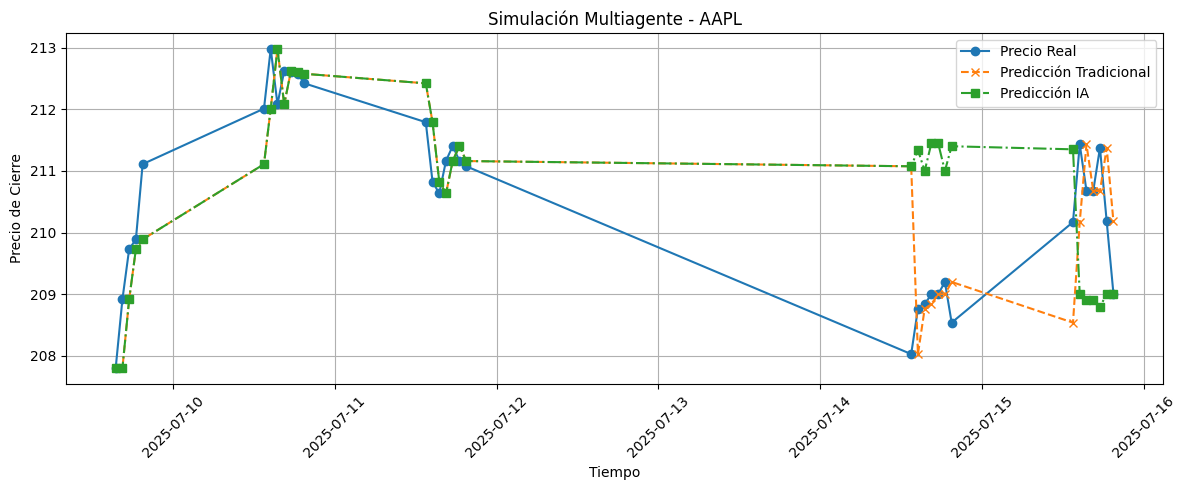

✔ Terminó AAPL
Iniciando simulación para MSFT...
min 501.5
max 504.7099914550781
{'fecha': '2025-07-14 13:30', 'valor': 503.5}
----------------------------
min 501.5
max 504.7099914550781
{'fecha': '2025-07-14 14:30', 'valor': 503.5}
----------------------------
min 501.5
max 504.7099914550781
{'fecha': '2025-07-14 15:30', 'valor': 503.170013}
----------------------------
min 501.5
max 504.7099914550781
{'fecha': '2025-07-14 16:30', 'valor': 503.5}
----------------------------
min 501.5
max 504.7099914550781
{'fecha': '2025-07-14 17:30', 'valor': 503.5}
----------------------------
min 501.5
max 504.7099914550781
{'fecha': '2025-07-14 18:30', 'valor': 503.5}
----------------------------
min 501.5
max 504.7099914550781
{'fecha': '2025-07-14 19:30', 'valor': 503.170013}
----------------------------
min 501.5499877929688
max 502.9700012207031
{'fecha': '2025-07-15 13:30', 'valor': 502.9}
----------------------------
min 501.5499877929688
max 502.9700012207031
{'fecha': '2025-07-15 14:30',

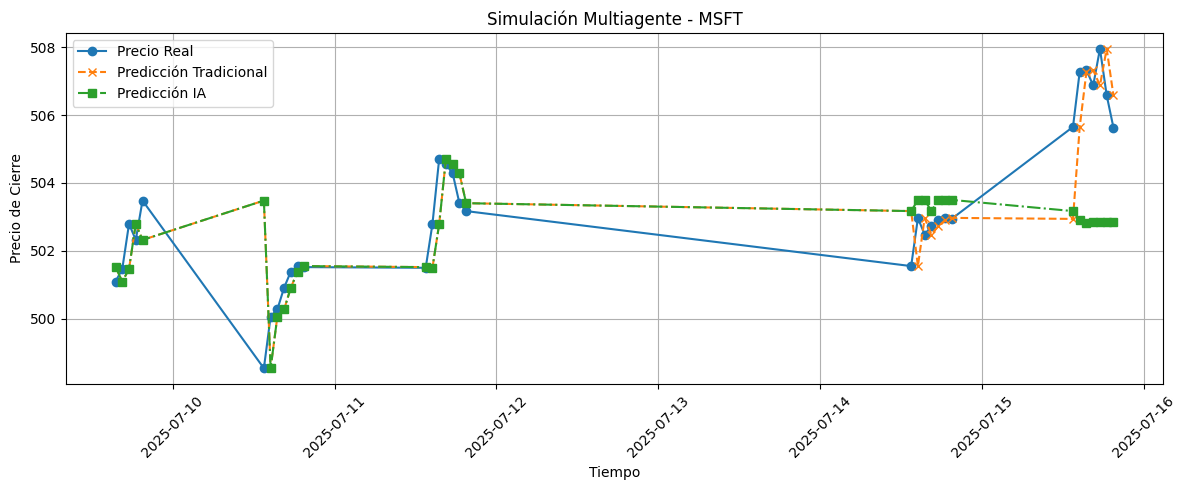

✔ Terminó MSFT
Iniciando simulación para GOOGL...
min 177.4450073242188
max 180.8677978515625
{'fecha': '2025-07-14 13:30', 'valor': 178.929993}
----------------------------
min 177.4450073242188
max 180.8677978515625
{'fecha': '2025-07-14 14:30', 'valor': 179.45}
----------------------------
min 177.4450073242188
max 180.8677978515625
{'fecha': '2025-07-14 15:30', 'valor': 179.45}
----------------------------
min 177.4450073242188
max 180.8677978515625
{'fecha': '2025-07-14 16:30', 'valor': 179.5}
----------------------------
min 177.4450073242188
max 180.8677978515625
{'fecha': '2025-07-14 17:30', 'valor': 179.45}
----------------------------
min 177.4450073242188
max 180.8677978515625
{'fecha': '2025-07-14 18:30', 'valor': 179.95}
----------------------------
min 177.4450073242188
max 180.8677978515625
{'fecha': '2025-07-14 19:30', 'valor': 179.75}
----------------------------
min 180.1699981689453
max 181.7299957275391
{'fecha': '2025-07-15 13:30', 'valor': 181.4}
-----------------

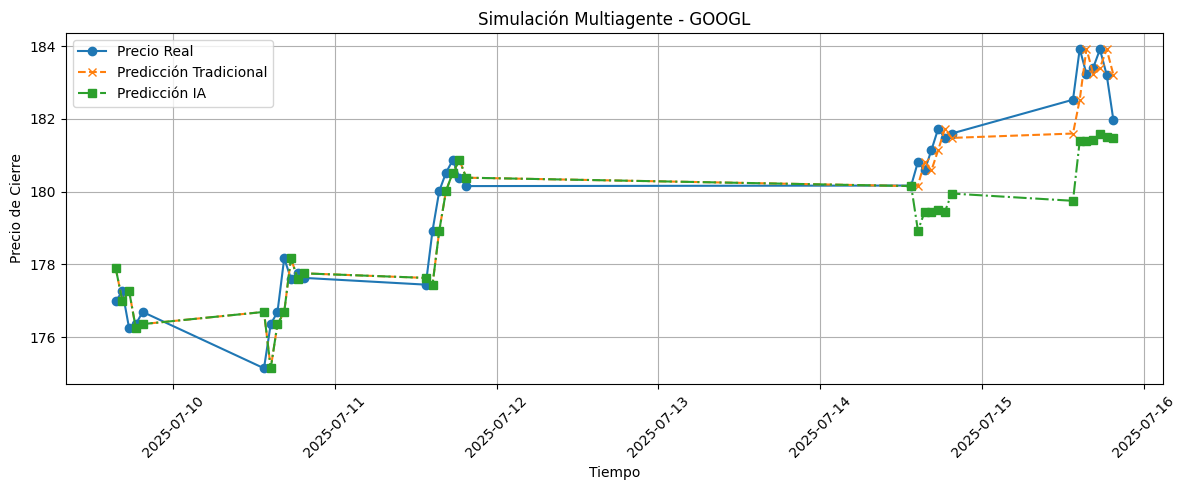

✔ Terminó GOOGL
Iniciando simulación para AMZN...
min 224.3755950927734
max 226.1000061035156
Error en predicción: 'choices'
min 224.3755950927734
max 226.1000061035156
Error en predicción: 'choices'
min 224.3755950927734
max 226.1000061035156
Error en predicción: 'choices'
min 224.3755950927734
max 226.1000061035156
Error en predicción: 'choices'
min 224.3755950927734
max 226.1000061035156
Error en predicción: 'choices'
min 224.3755950927734
max 226.1000061035156
Error en predicción: 'choices'
min 224.3755950927734
max 226.1000061035156
Error en predicción: 'choices'
min 225.3056030273438
max 225.9949951171875
{'fecha': '2025-07-15 13:30', 'valor': 225.6}
----------------------------
min 225.3056030273438
max 225.9949951171875
{'fecha': '2025-07-15 14:30', 'valor': 226.050003}
----------------------------
min 225.3056030273438
max 225.9949951171875
{'fecha': '2025-07-15 15:30', 'valor': 226.050003}
----------------------------
min 225.3056030273438
max 225.9949951171875
{'fecha': '202

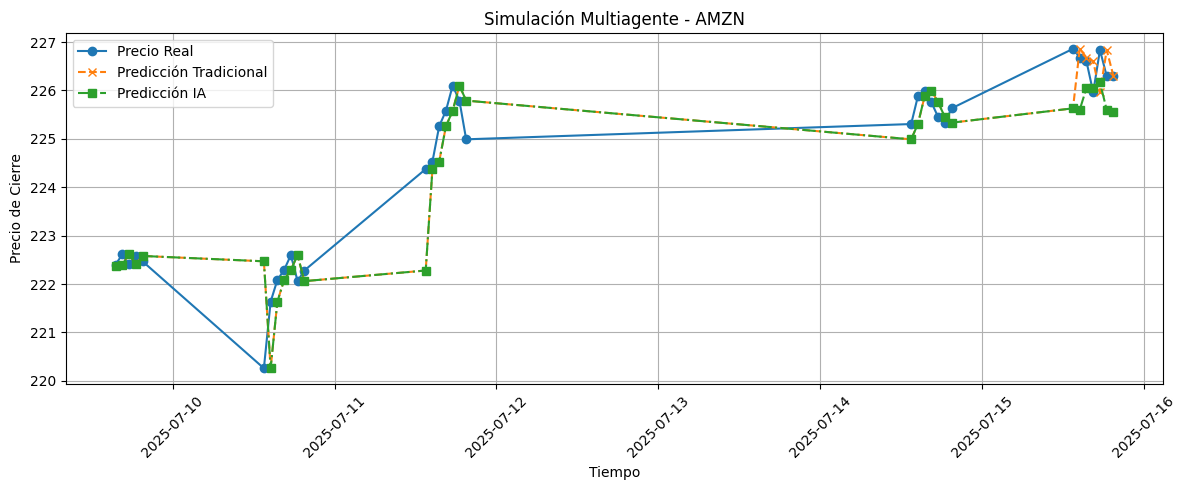

✔ Terminó AMZN
Iniciando simulación para NVDA...
min 164.8800048828125
max 167.3598937988281
Error en predicción: 'choices'
min 164.8800048828125
max 167.3598937988281
Error en predicción: 'choices'
min 164.8800048828125
max 167.3598937988281
Error en predicción: 'choices'
min 164.8800048828125
max 167.3598937988281
Error en predicción: 'choices'
min 164.8800048828125
max 167.3598937988281
Error en predicción: 'choices'
min 164.8800048828125
max 167.3598937988281
Error en predicción: 'choices'
min 164.8800048828125
max 167.3598937988281
Error en predicción: 'choices'
min 163.7200012207031
max 165.0800933837891
{'fecha': '2025-07-15 13:30', 'valor': 164.4}
----------------------------
min 163.7200012207031
max 165.0800933837891
{'fecha': '2025-07-15 14:30', 'valor': 164.7547}
----------------------------
min 163.7200012207031
max 165.0800933837891
{'fecha': '2025-07-15 15:30', 'valor': 164.9}
----------------------------
min 163.7200012207031
max 165.0800933837891
{'fecha': '2025-07-15 

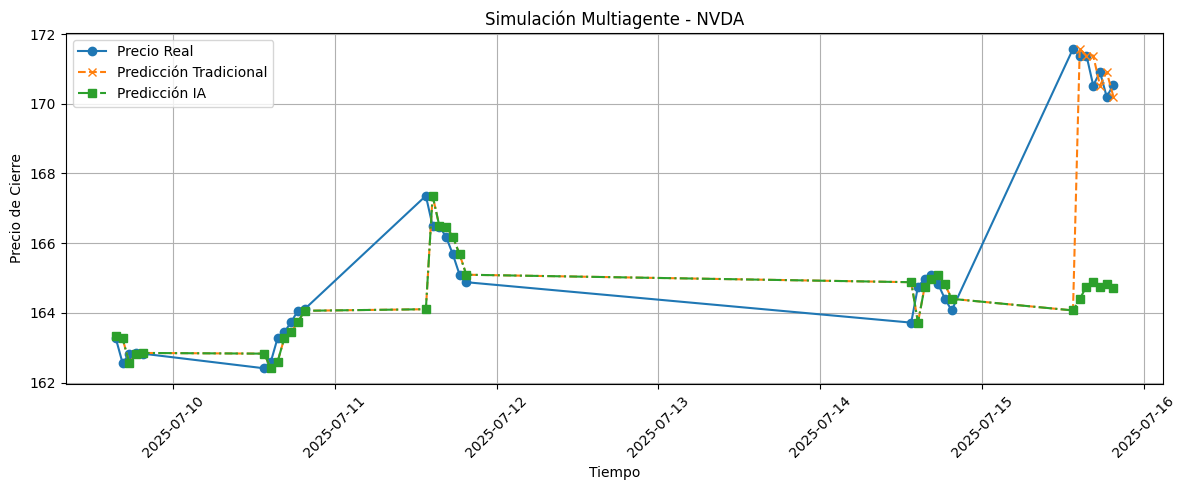

✔ Terminó NVDA
Iniciando simulación para META...
min 716.260009765625
max 721.1199951171875
{'fecha': '2025-07-14 13:30', 'valor': 719.1199951171875}
----------------------------
min 716.260009765625
max 721.1199951171875
{'fecha': '2025-07-14 14:30', 'valor': 718.669983}
----------------------------
min 716.260009765625
max 721.1199951171875
{'fecha': '2025-07-14 15:30', 'valor': 720.84}
----------------------------
min 716.260009765625
max 721.1199951171875
{'fecha': '2025-07-14 16:30', 'valor': 720.0}
----------------------------
min 716.260009765625
max 721.1199951171875
{'fecha': '2025-07-14 17:30', 'valor': 720.5}
----------------------------
min 716.260009765625
max 721.1199951171875
{'fecha': '2025-07-14 18:30', 'valor': 720.0}
----------------------------
min 716.260009765625
max 721.1199951171875
{'fecha': '2025-07-14 19:30', 'valor': 719.1199951171875}
----------------------------
min 720.1599731445312
max 726.5349731445312
{'fecha': '2025-07-15 13:30', 'valor': 723.0}
-----

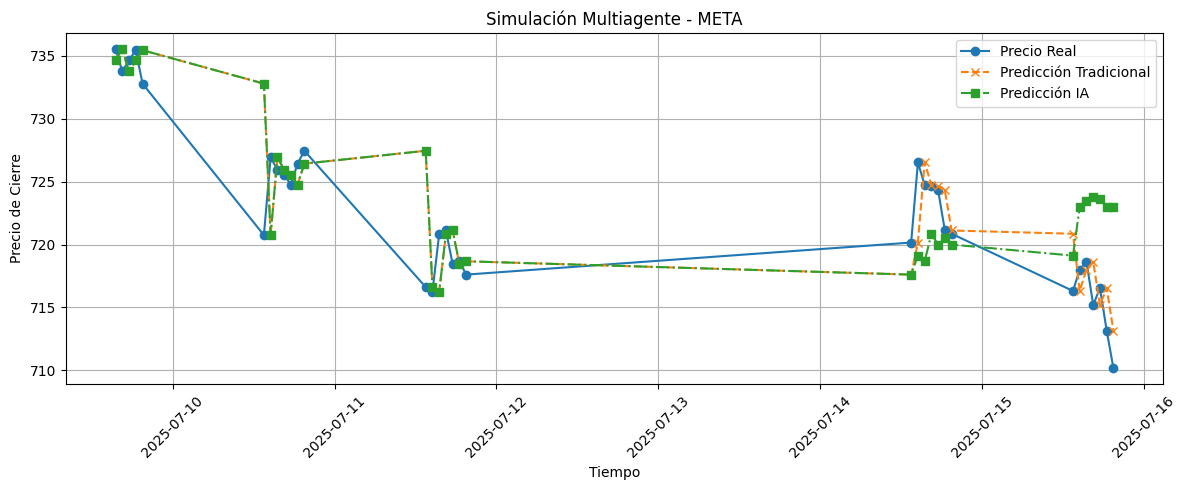

✔ Terminó META
Iniciando simulación para BRK-B...
min 471.960693359375
max 476.3299865722656
{'fecha': '2025-07-14 13:30', 'valor': 473.809998}
----------------------------
min 471.960693359375
max 476.3299865722656
{'fecha': '2025-07-14 14:30', 'valor': 474.200012}
----------------------------
min 471.960693359375
max 476.3299865722656
{'fecha': '2025-07-14 15:30', 'valor': 473.809998}
----------------------------
min 471.960693359375
max 476.3299865722656
{'fecha': '2025-07-14 16:30', 'valor': 474.25}
----------------------------
min 471.960693359375
max 476.3299865722656
{'fecha': '2025-07-14 17:30', 'valor': 474.809998}
----------------------------
min 471.960693359375
max 476.3299865722656
{'fecha': '2025-07-14 18:30', 'valor': 473.809998}
----------------------------
min 471.960693359375
max 476.3299865722656
{'fecha': '2025-07-14 19:30', 'valor': 476.0}
----------------------------
min 476.4100036621094
max 477.1176147460938
{'fecha': '2025-07-15 13:30', 'valor': 476.85}
-------

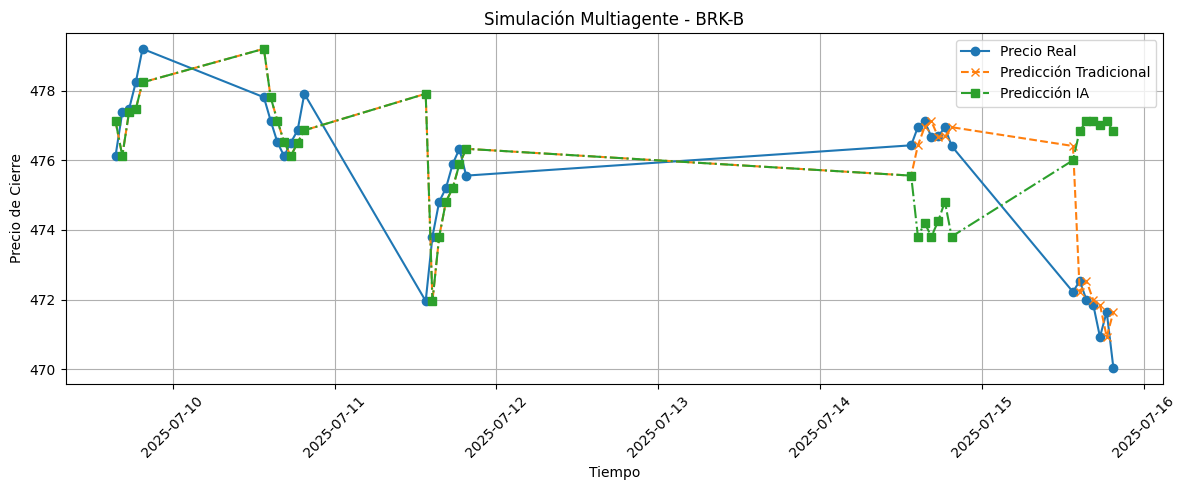

✔ Terminó BRK-B
Iniciando simulación para TSLA...
min 307.7103881835938
max 313.5
{'fecha': '2025-07-14 13:30', 'valor': 312.679993}
----------------------------
min 307.7103881835938
max 313.5
{'fecha': '2025-07-14 14:30', 'valor': 311.0}
----------------------------
min 307.7103881835938
max 313.5
{'fecha': '2025-07-14 15:30', 'valor': 312.5}
----------------------------
min 307.7103881835938
max 313.5
{'fecha': '2025-07-14 16:30', 'valor': 312.679993}
----------------------------
min 307.7103881835938
max 313.5
{'fecha': '2025-07-14 17:30', 'valor': 312.679993}
----------------------------
min 307.7103881835938
max 313.5
{'fecha': '2025-07-14 18:30', 'valor': 312.679993}
----------------------------
min 307.7103881835938
max 313.5
{'fecha': '2025-07-14 19:30', 'valor': 313.0}
----------------------------
min 314.2496948242188
max 316.9100036621094
Error en predicción: 'choices'
min 314.2496948242188
max 316.9100036621094
Error en predicción: 'choices'
min 314.2496948242188
max 316.9

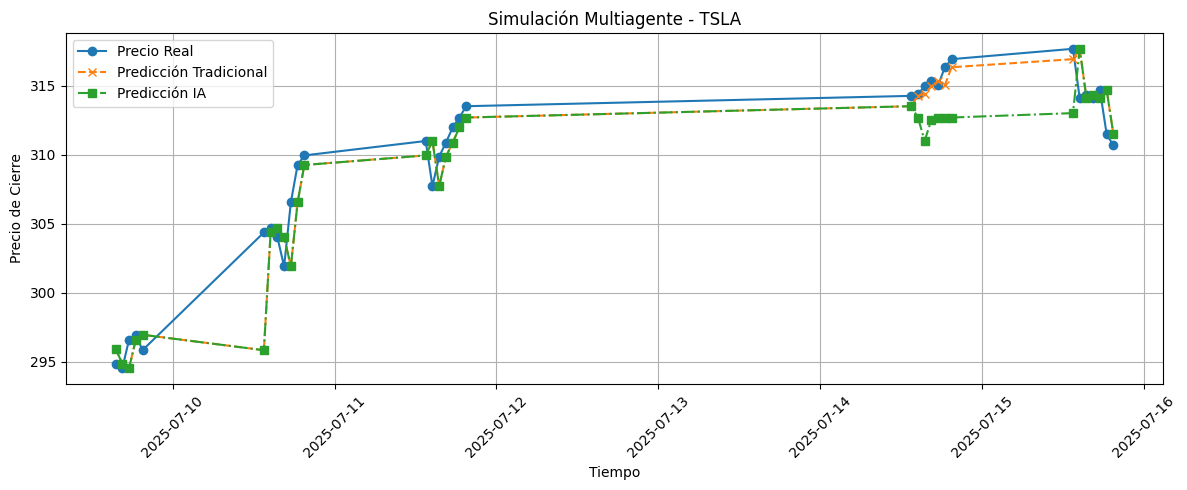

✔ Terminó TSLA
Iniciando simulación para TSM...
min 230.3200073242188
max 231.5700073242188
Error en predicción: 'choices'
min 230.3200073242188
max 231.5700073242188
Error en predicción: 'choices'
min 230.3200073242188
max 231.5700073242188
Error en predicción: 'choices'
min 230.3200073242188
max 231.5700073242188
Error en predicción: 'choices'
min 230.3200073242188
max 231.5700073242188
Error en predicción: 'choices'
min 230.3200073242188
max 231.5700073242188
Error en predicción: 'choices'
min 230.3200073242188
max 231.5700073242188
Error en predicción: 'choices'
min 228.0350036621094
max 229.5899963378906
Error en predicción: 'choices'
min 228.0350036621094
max 229.5899963378906
Error en predicción: 'choices'
min 228.0350036621094
max 229.5899963378906
Error en predicción: 'choices'
min 228.0350036621094
max 229.5899963378906
Error en predicción: 'choices'
min 228.0350036621094
max 229.5899963378906
Error en predicción: 'choices'
min 228.0350036621094
max 229.5899963378906
Error en

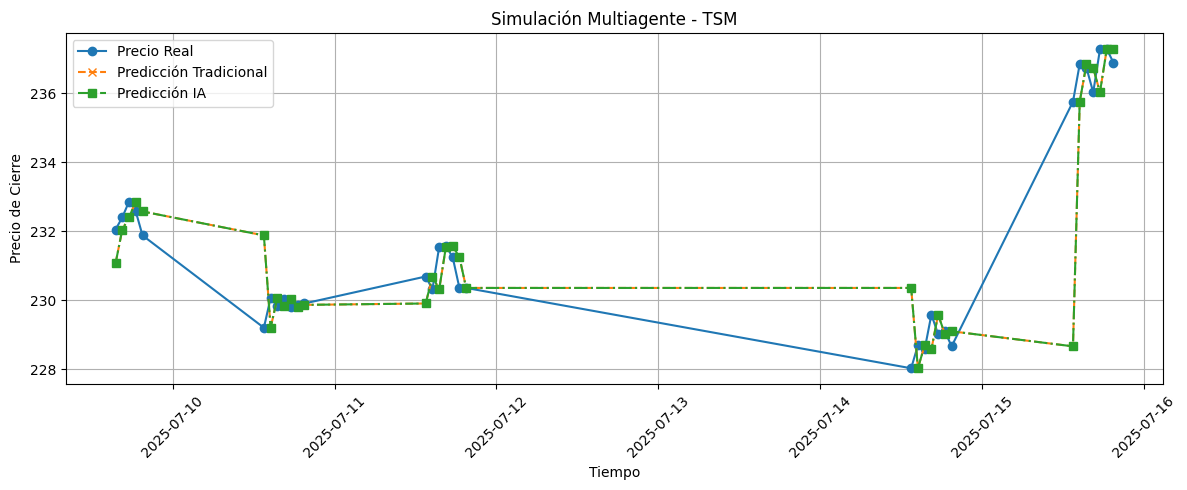

✔ Terminó TSM
Iniciando simulación para JPM...
min 285.3599853515625
max 286.9505920410156
{'fecha': '2025-07-14 13:30', 'valor': 286.550002}
----------------------------
min 285.3599853515625
max 286.9505920410156
Error en predicción: '{' was never closed (<string>, line 1)
min 285.3599853515625
max 286.9505920410156


KeyboardInterrupt: 

In [7]:
# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    # Cargar datos
    df = pd.read_excel("historico_top10_indicadores_completos.xlsx")
    env = MarketEnvironment(df)
    env.run()